In [20]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots 
import math

In [21]:
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
x = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1)
y = torch.sin(math.pi*x) + 0.2*torch.randn(x.size())  
# 载入同样的训练数据，这个数据不论任何电脑，任何时间，数据应该是一样的

<function matplotlib.pyplot.show(close=None, block=None)>

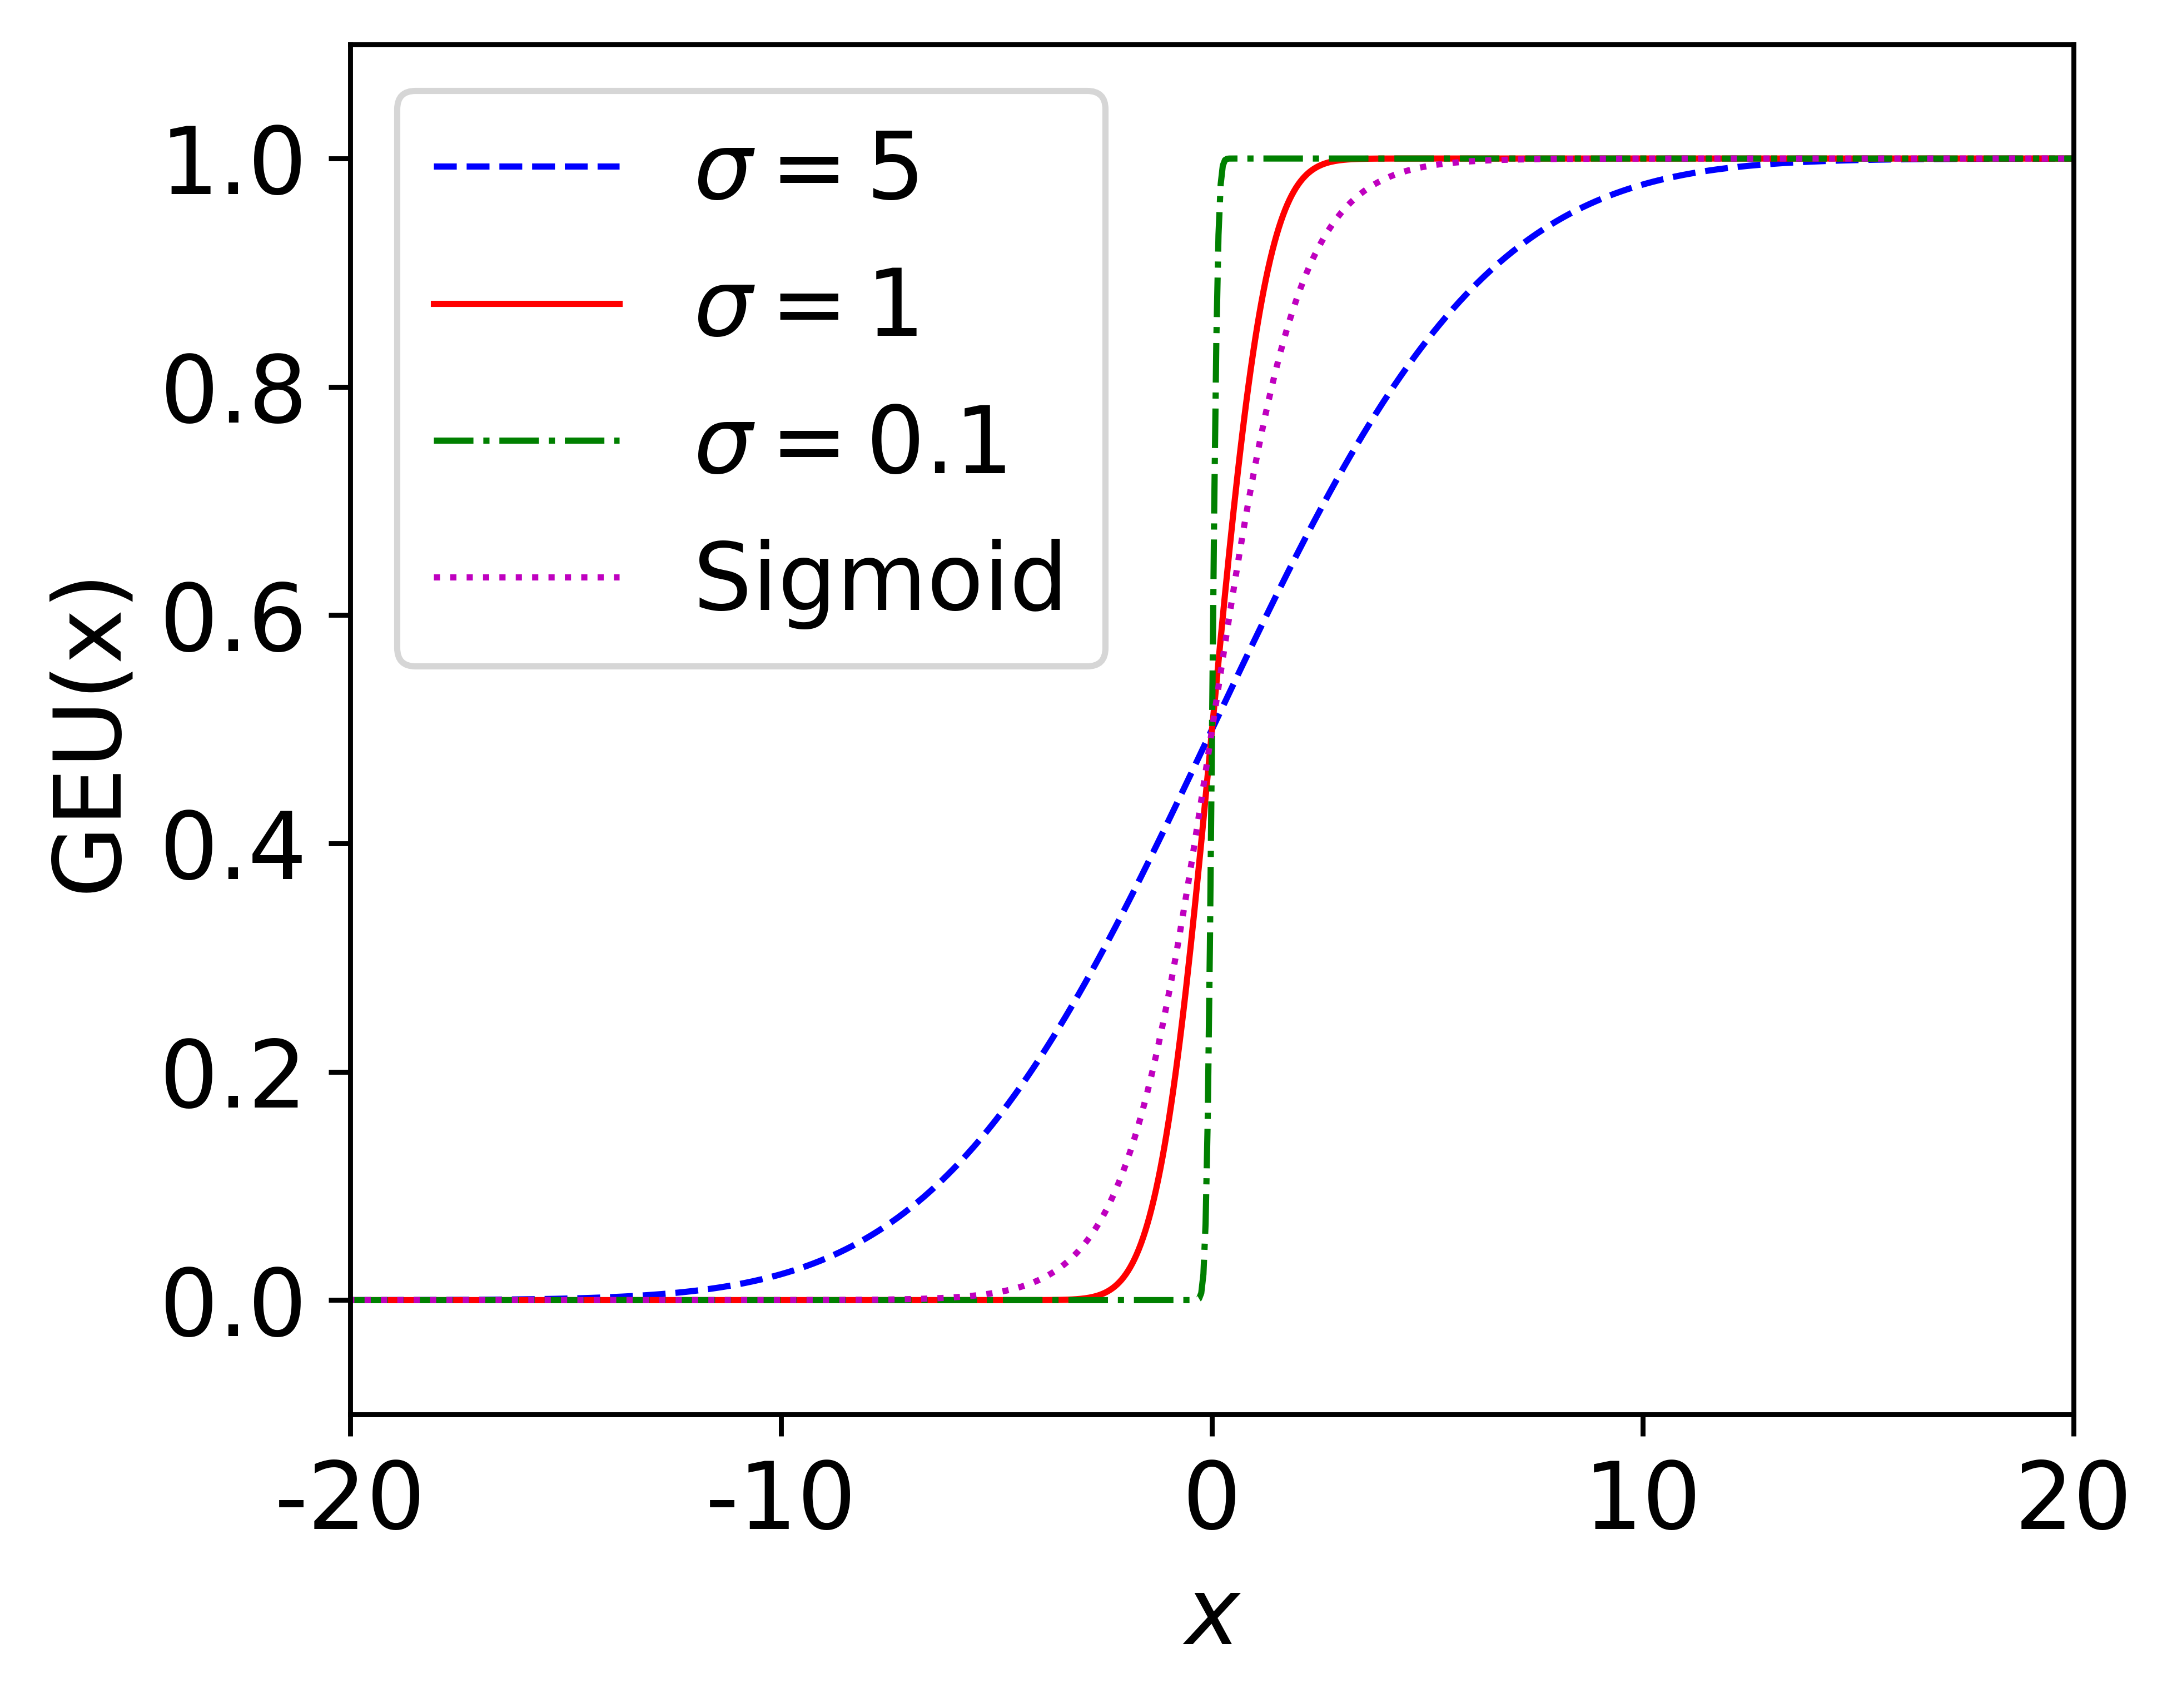

In [22]:
class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # 1个可学习参数 sigma
        
    def forward(self, input):
        temp = 0.5+torch.erf(input/torch.abs(self.sigma)/math.sqrt(2))/2  # 前向传播
        return temp
###这个激活函数的来源就是设高斯分布，F是累计分布函数=1/2+torch.erf(x/sigma/sqrt(2))/2
###那么激活函数1-F(-x)=得到GEU（Gaussian error unit）,是一种饱和型激活函数，里面含有学习参数self.sigma
###随着sigma的变化，GEU激活函数从阈值函数变到线性函数

plt.rcParams ['font.serif'] = ['Times New Roman']#字体
mpl.rcParams['figure.dpi'] = 800#分辨率
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('GEU(x)', fontsize=15)
ax.set_xlim(-20, 20)
ax.set_ylim(-0.1, 1.1)
############sigma分别取5，1，0.1，可以看出GELU函数
pdfx = torch.unsqueeze(torch.linspace(-50, 50, 2001), dim=1)
pdfy=0.5+torch.erf((pdfx)/5/math.sqrt(2))/2
ax.plot(pdfx.data.numpy(), pdfy.data.numpy(), 'b--', lw=1,label='$\sigma=5$')

pdfyy=0.5+torch.erf((pdfx)/math.sqrt(2))/2
ax.plot(pdfx.data.numpy(), pdfyy.data.numpy(), 'r-', lw=1,label='$\sigma=1$')

pdfyyy=0.5-torch.erf((-pdfx)/0.1/math.sqrt(2))/2
ax.plot(pdfx.data.numpy(), pdfyyy.data.numpy(), 'g-.', lw=1,label='$\sigma=0.1$')
##为了对比，画出sigmoid函数
Sigm=1/(1+torch.exp(-pdfx))
ax.plot(pdfx.data.numpy(), Sigm.data.numpy(), 'm:',lw=1,label='Sigmoid')
ax.legend(loc='upper left', fontsize=15)
plt.show

In [25]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.custom1 = GEU()  # 自定义激活函数层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):

        x = self.hidden1(x)
        x = self.custom1(x)
        x = self.predict(x)  # 前向传播过程
        return x
net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
loss_func = torch.nn.MSELoss().to(device)  # MSE损失函数
x = x.to(device)
y = y.to(device)

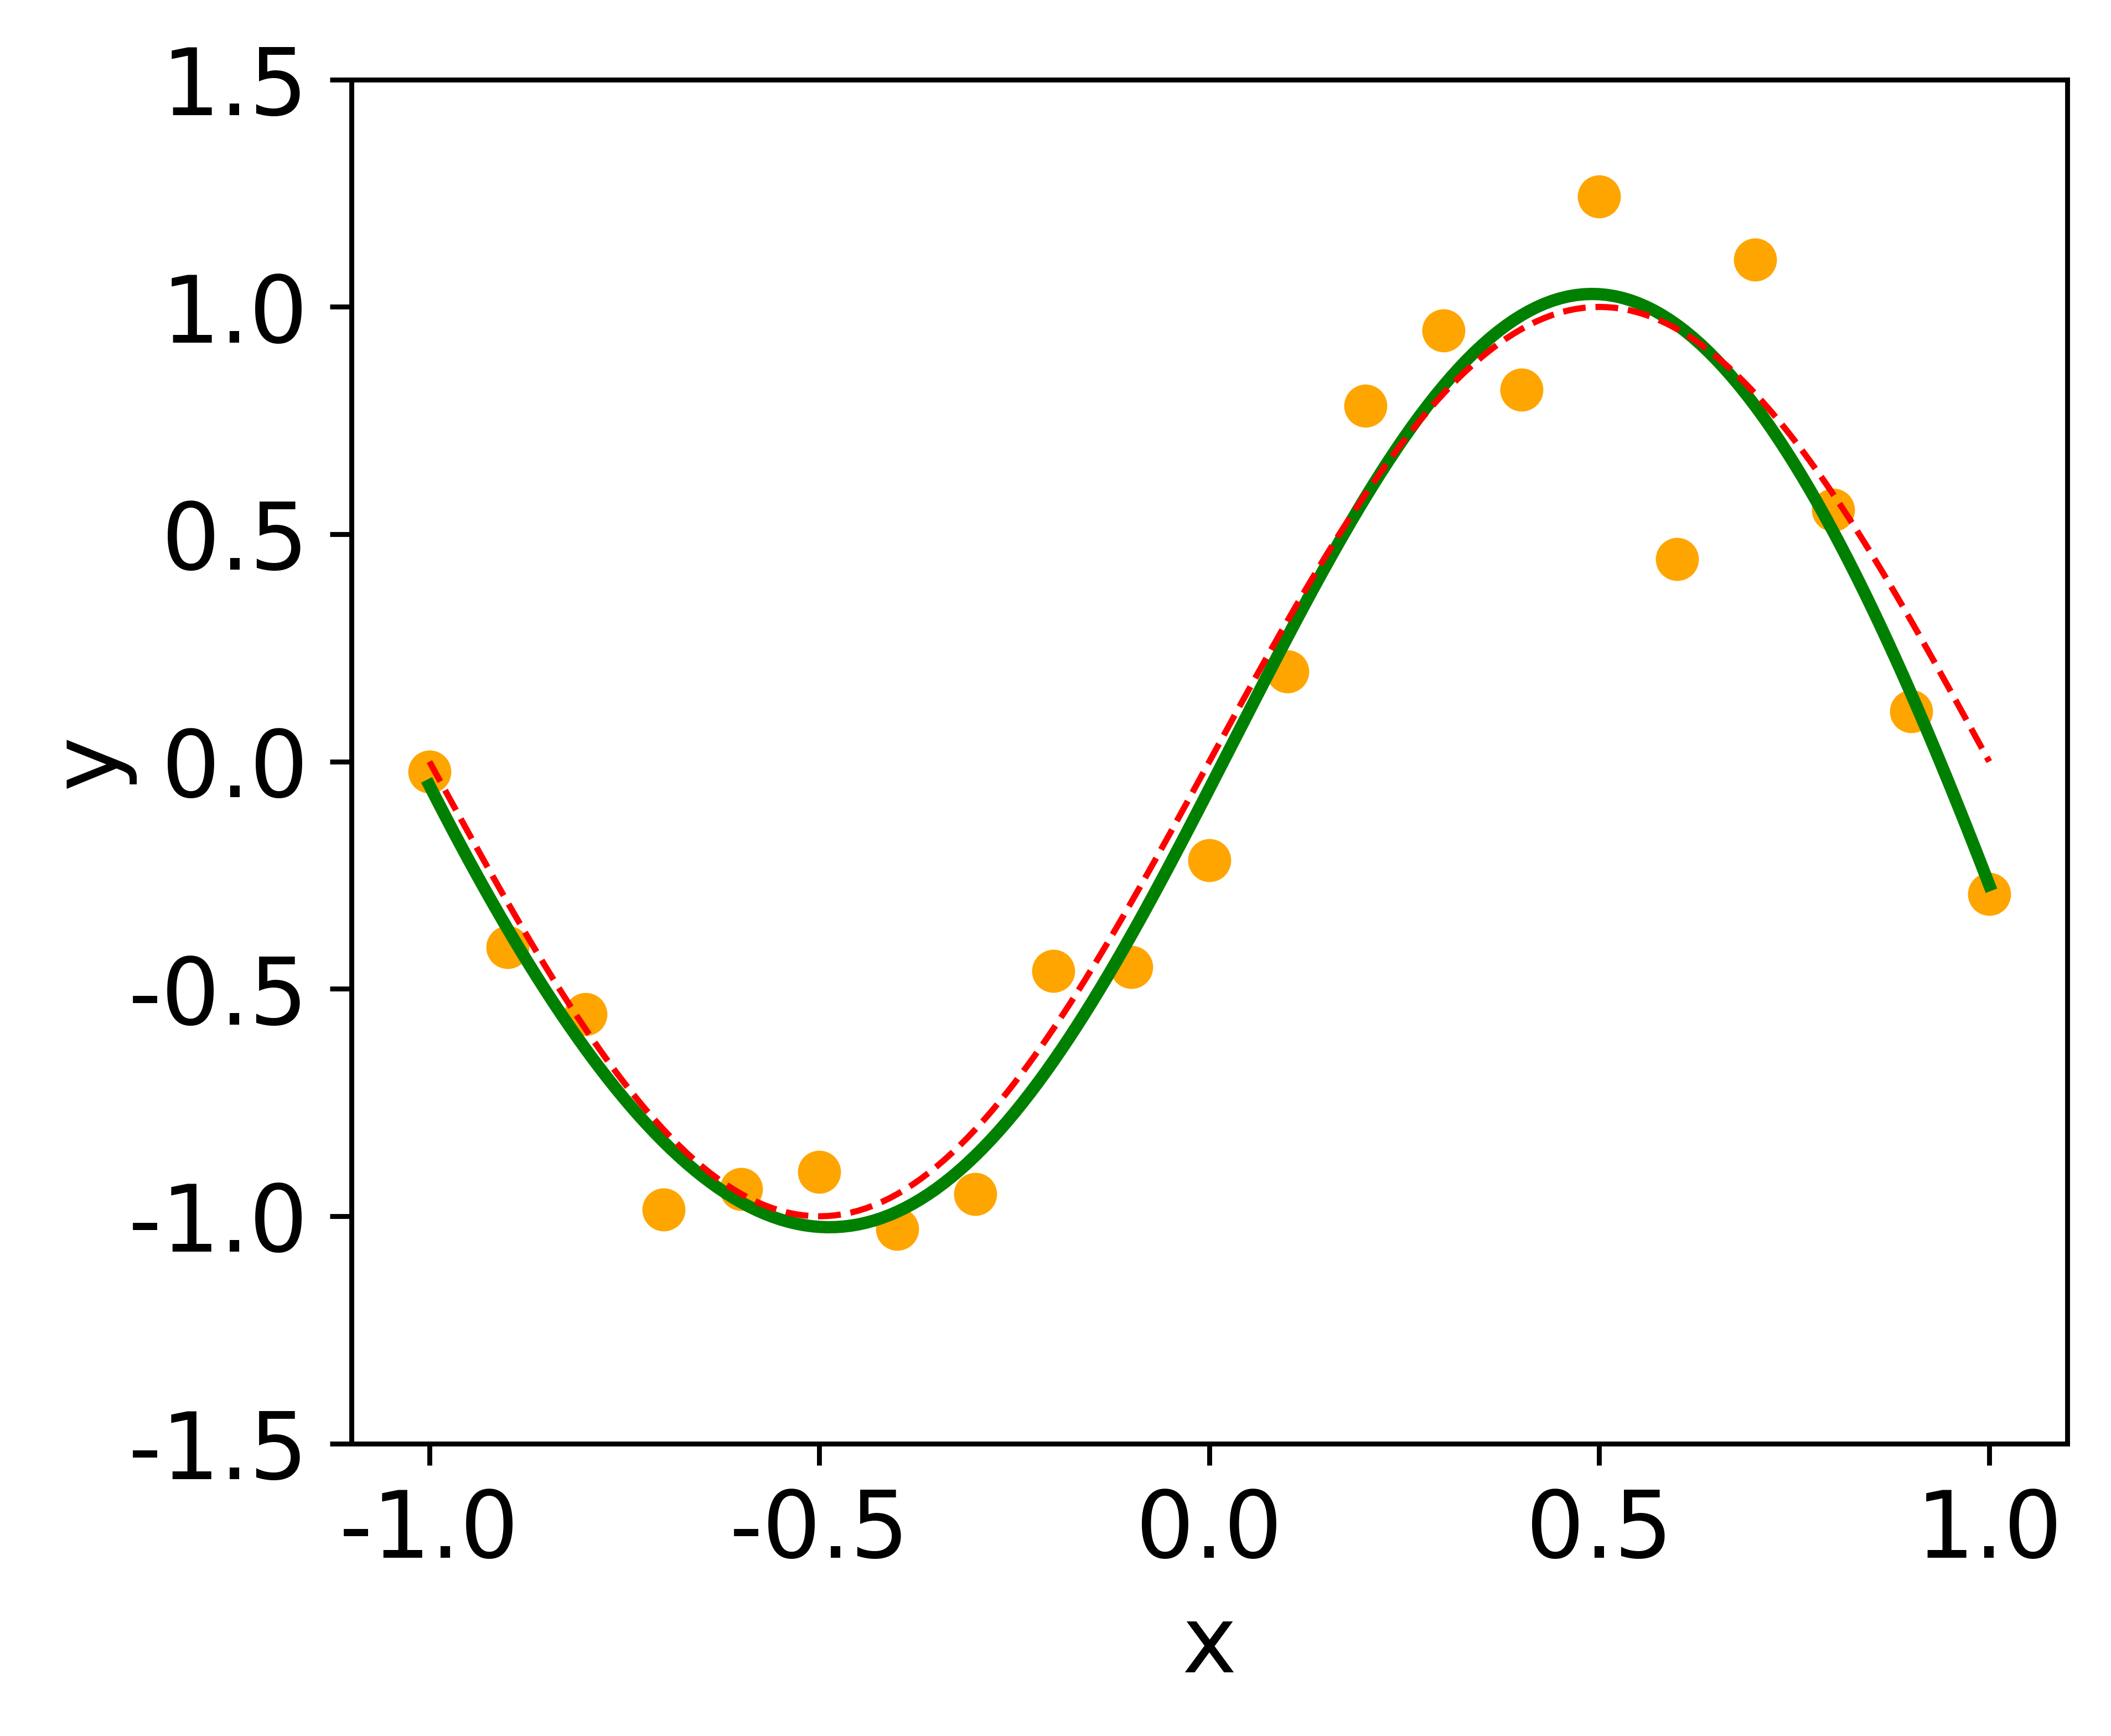

In [26]:
epoch = 20000
para0 = torch.zeros(epoch)  # para0用来记录训练时每个epoch时的loss函数值
para1 = torch.zeros(epoch)  # para1记录激活函数中学习参数sigma
########网络中隐层共10个GEU激活函数，我们设它们的学习参数sigma是相同的，
########并且初始值从17开始，为啥选择17，选择别的初始值比如1，同样也出现过拟合
########比较大的初始值防止过拟合现象的效果好一些，这个是有理论根据，请参考文献
# Li Z, Ma C, Wu L. Complexity measures for neural networks with general
# activation functions using path-based norms. 2020, http://dx.doi.org/10.48550/
# arXiv.2009.06132

# Fabing Duan, François Chapeau-Blondeau, Derek Abbott，Optimized injection of noise in 
# activation functions to improve generalization of neural networks，
# Chaos, Solitons and Fractals 178 (2024) 114363，https://doi.org/10.1016/j.chaos.2023.114363

z=net.custom1.sigma#这样是找到网络模型net中custom1激活函数的参数sigma 
nn.init.constant_(z,17)#初始选择为17整数

for t in range(epoch):

    prediction = net(x)  # 前向过程
    loss = loss_func(prediction, y) # 计算mse

    #记录loss和参数sigma的变化
    para0[t] = loss.data
    para1[t] = net.custom1.sigma.data
    ##后向传播更新
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)    # 反向传播
    optimizer.step()        # 更新参数
    
#画出网络学习曲线
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [27]:
print(para0[epoch-1])#训练的MSE最后值

tensor(0.0301)


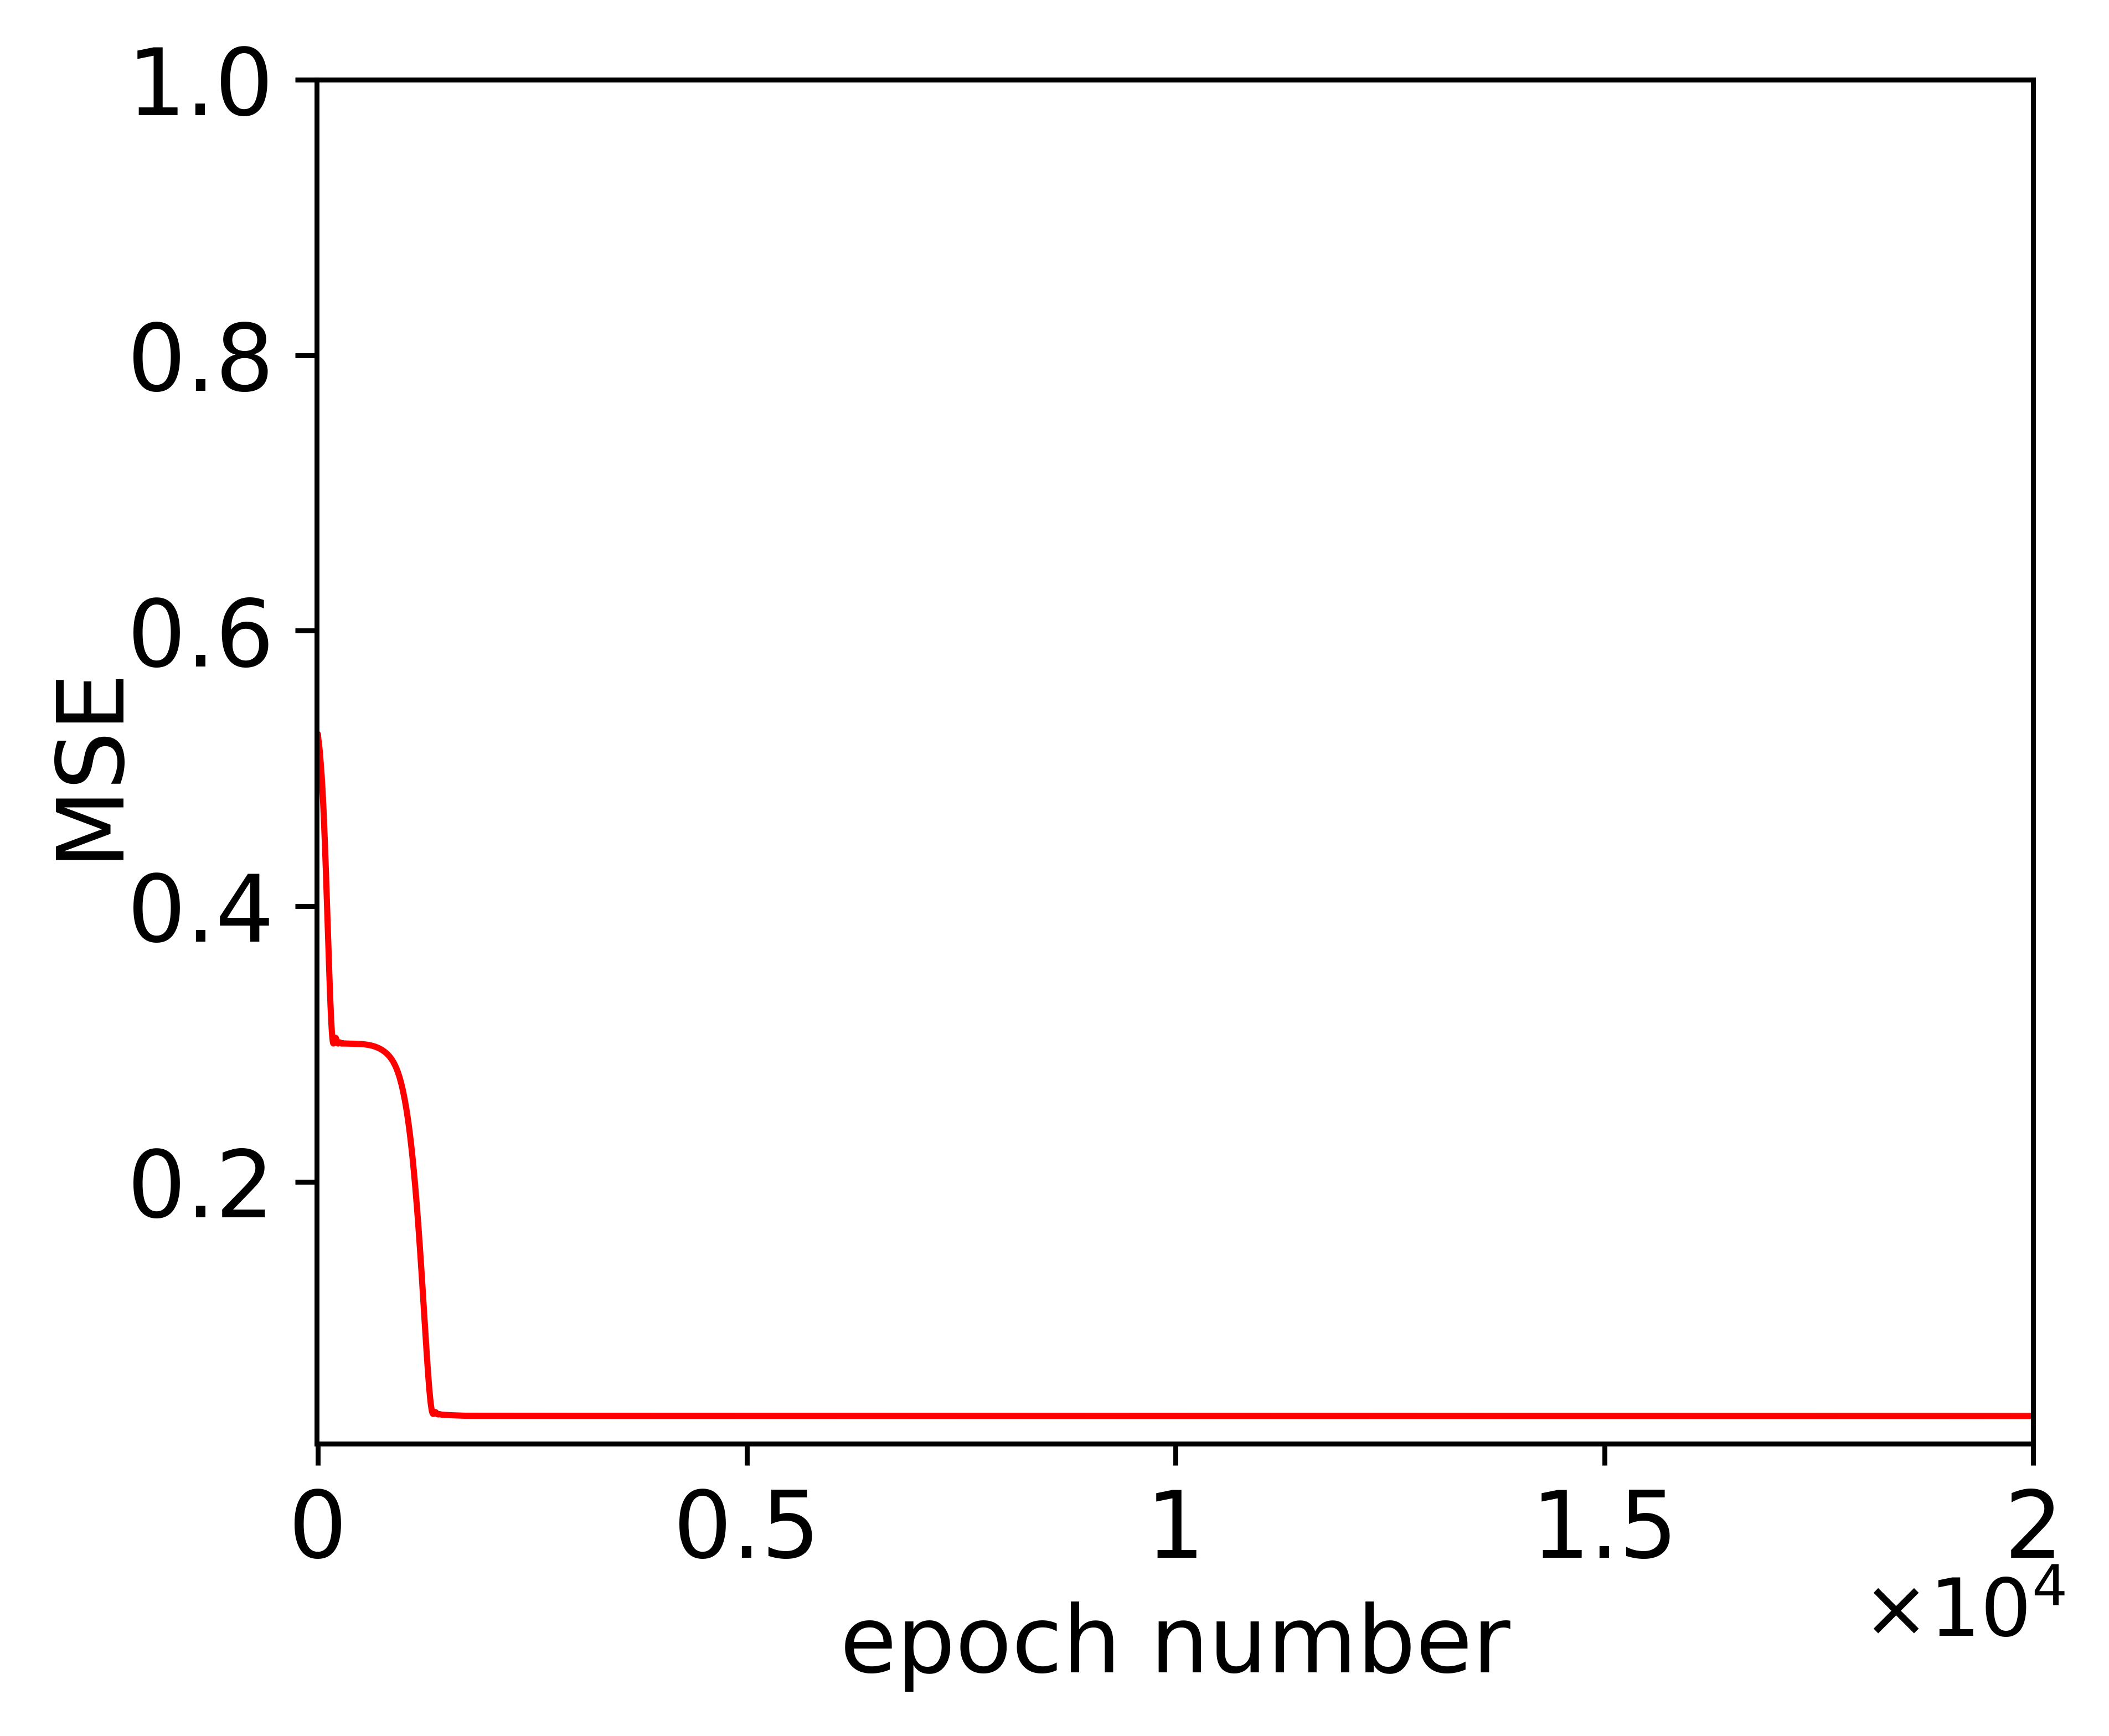

In [48]:
#画出loss学习曲线
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('MSE', fontsize=15, labelpad = -1.2)
ax.set_xlim(-10, 20000)
ax.set_ylim(0.01, 1)
ax.plot(para0.data.numpy(), 'r-', lw=1)
ax.text(18000, -0.13, r'$ \times 10^4$',fontdict={'size': 13, 'color':  'black'})
#在x下方标记\times 10^4
plt.xticks([0,5000,10000,15000,20000],[0, 0.5, 1, 1.5, 2])
#把坐标轴改成[0, 0.5, 1, 1.5, 2]
plt.show()

In [50]:
#可以看出MSE非常快地收敛到0.0301，1400步就大致收敛到0.03，后面训练保持不动
print(para0[1400])

tensor(0.0312)


Text(19000, 2.2, '$ \\times 10^4$')

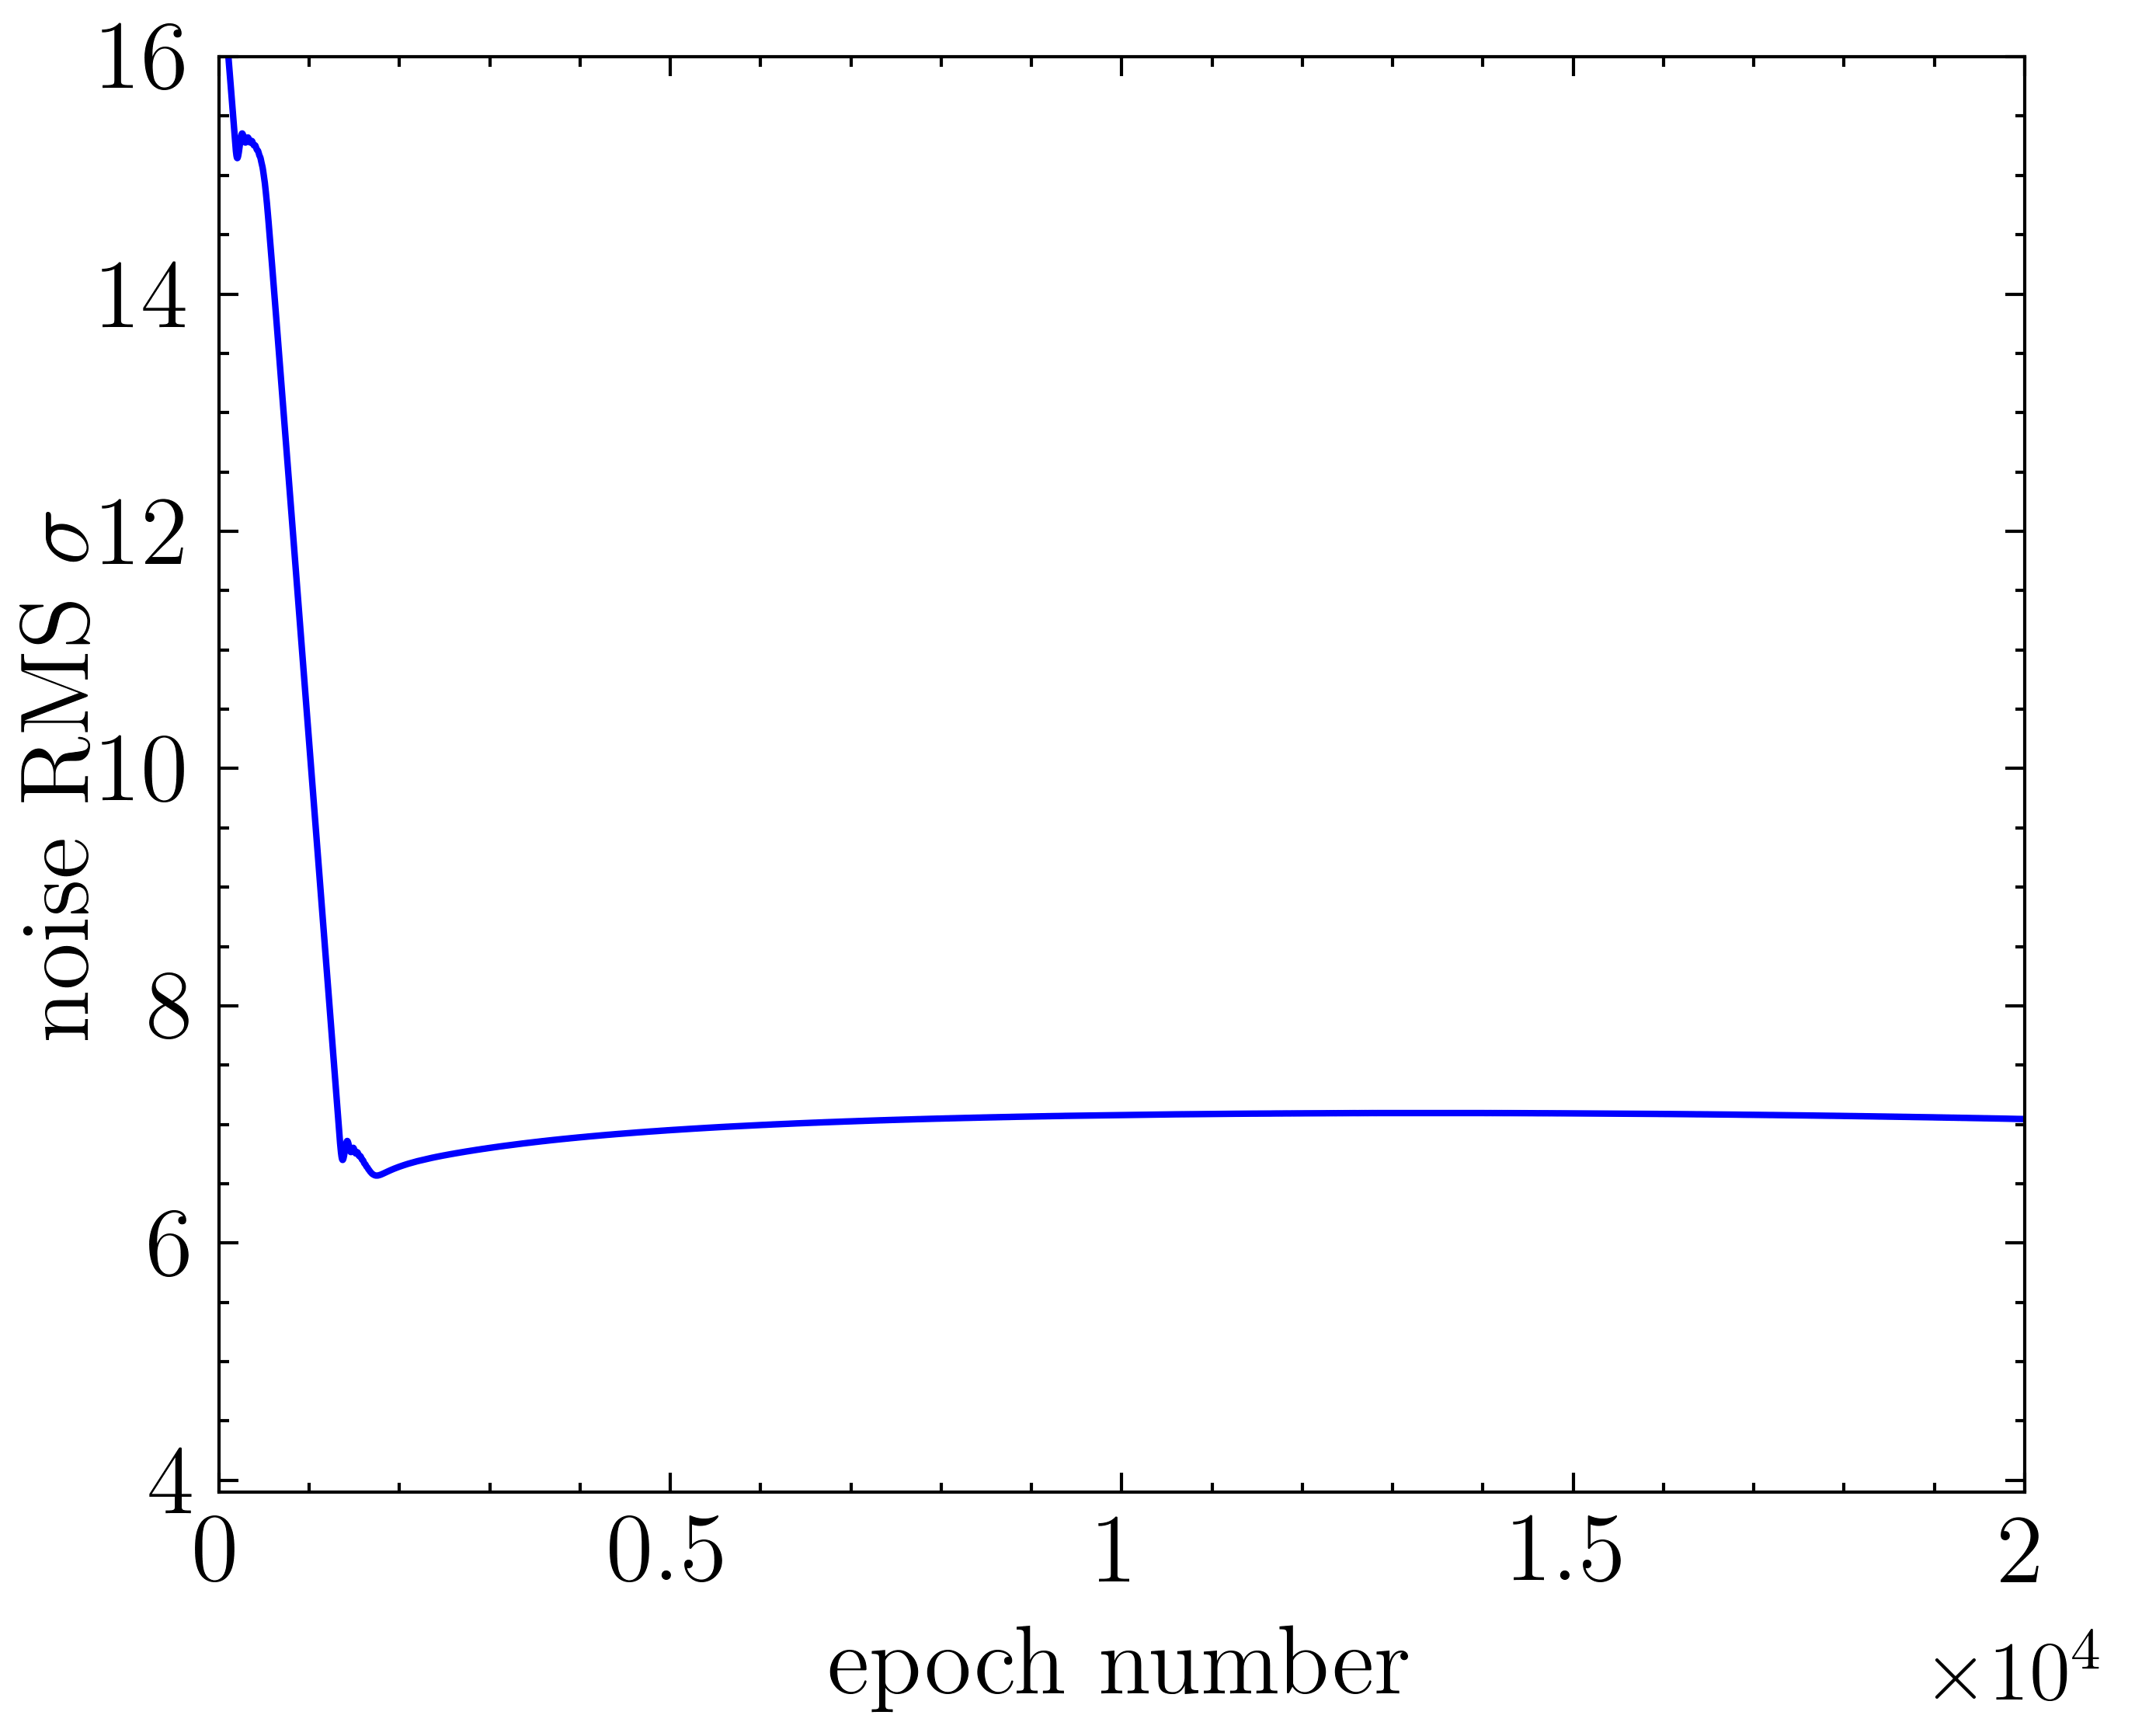

In [55]:
###我们也可以画出新定义的激活函数中sigma参数的梯度学习变化图如下
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('noise RMS $\sigma$', fontsize=15, labelpad = -1.2)
ax.set_xlim(-1, 20000)
ax.set_ylim(3.9, 16)
ax.plot(para1.data.numpy(), 'b-', lw=1)

#ax.text(-3000, 16, '(c)',fontdict={'size': 15, 'color':  'black'})
plt.xticks([0,5000,10000,15000,20000],[0, 0.5, 1, 1.5, 2])
ax.text(19000, 2.2, r'$ \times 10^4$',fontdict={'size': 13, 'color':  'black'})
#fig.savefig('D:/IEEE 2022 general AF/fig3c.eps', dpi=800)

In [56]:
#你可以存这些参数到csv文件
#frame1 = pd.DataFrame(para0.data.numpy()) #loss
#frame1.to_csv('D:/IEEE 2022 general AF/lossthreshold.csv', index=False)
#frame2 = pd.DataFrame(para1.data.numpy()) #sigma
#frame2.to_csv('D:/IEEE 2022 general AF/noisesigma.csv', index=False)

In [57]:
##############测试
SEED = 4321

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

xx = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)#这里我们采样数目不一样
yy = torch.sin(math.pi*xx) + 0.2*torch.randn(xx.size())

prediction2 = net(xx)  # 前向过程
loss2 = loss_func(prediction2, yy)     # 计算loss，通过prediction和y的差来计算mse
print(loss2.data)# 是10^{-2}次级别，与拟合的误差相比，泛化误差不大，同一个数量级

tensor(0.0416)
